## Implementing Portfolio Insurance (CPPI) and Drawdown constraints

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import edhek_risk_kit as erk

In [6]:
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [13]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

1. Cushion - (Asser Value - Floor Value)
2. Compute an allocation to safe and risky asstes (m * risk_budget)
3. Recompute the asset value based on the returns

In [14]:
def compound1(r):
    return (1+r).prod() - 1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [15]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [16]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [18]:
%timeit compound1(risky_r)

55.4 μs ± 507 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
%timeit compound2(risky_r)

52.4 μs ± 1.56 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Back to CPPI

In [43]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    # print(account_value)
    cushion = (account_value - floor_value) / account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    ## Update the account value for this time step
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

In [44]:
account_history

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489
...,...,...,...
2018-08,1078.784329,2461.732061,4155.508933
2018-09,1073.786842,2414.220632,4163.404400
2018-10,979.057951,2282.645608,4098.038951
2018-11,964.047446,2348.614066,4335.315406


<Axes: >

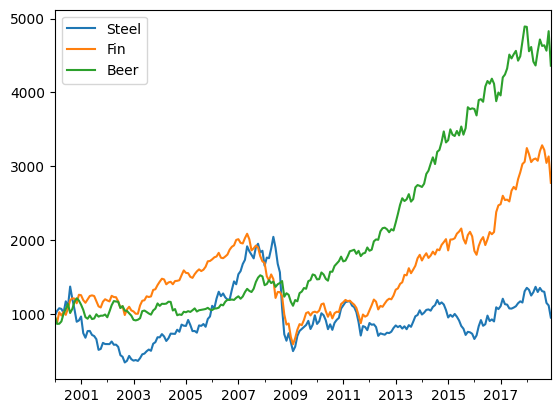

In [52]:
risky_wealth = start * (1 + risky_r).cumprod()
risky_wealth.plot()

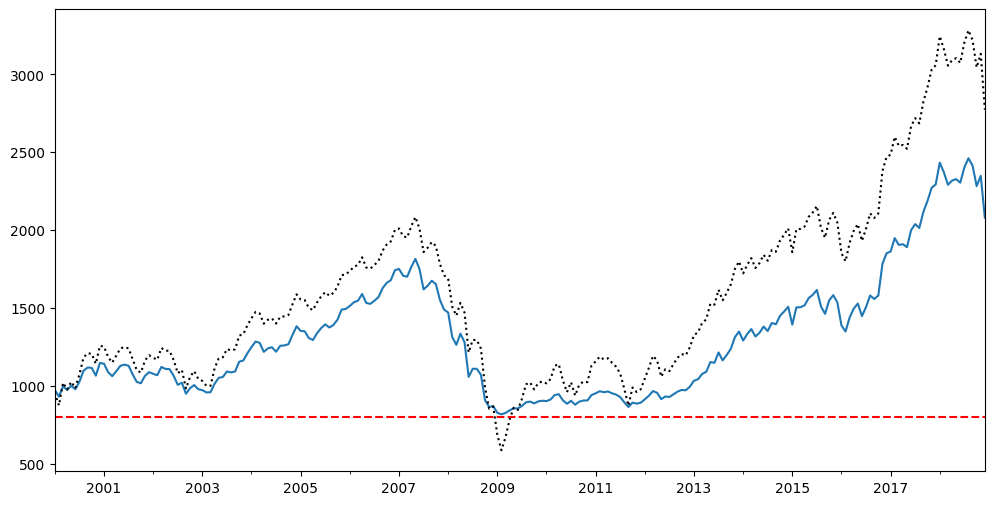

In [60]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

<Axes: >

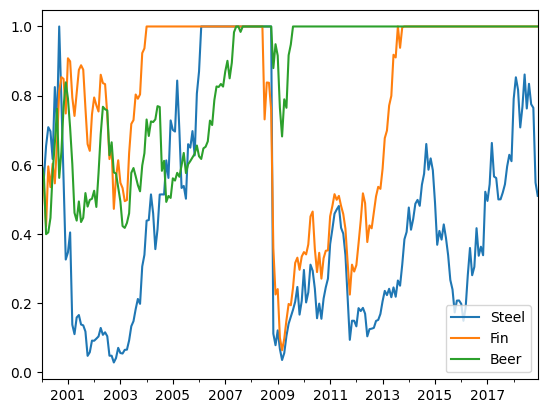

In [58]:
risky_w_history.plot()

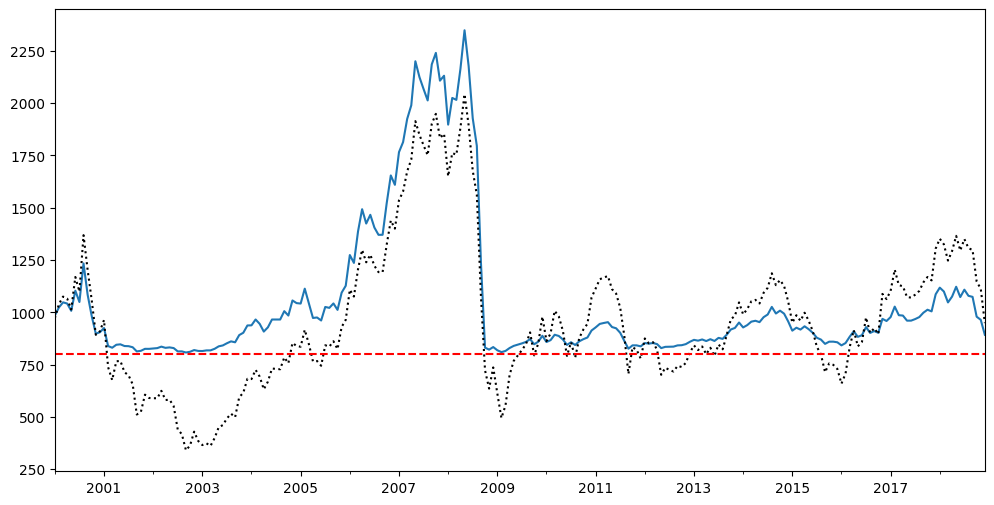

In [61]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [62]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.090173,-0.326334,4.144381,0.150139,0.208117,-0.355301,-0.758017
Fin,0.055166,0.055688,-0.533218,4.995534,0.091224,0.132175,0.438963,-0.718465
Beer,0.080598,0.040104,-0.493545,4.173881,0.063015,0.091442,1.227381,-0.271368


In [89]:
btr = erk.run_cppi(risky_r)

<Axes: >

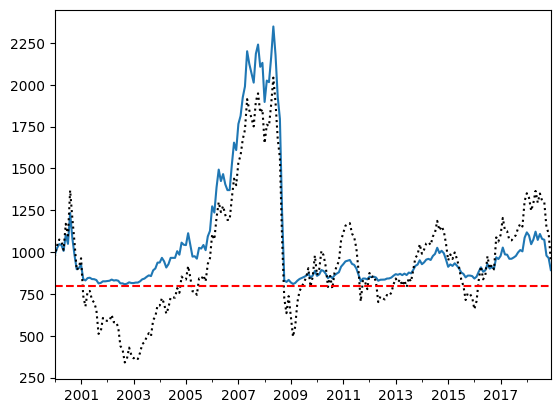

In [90]:
btr['Wealth']['Steel'].plot()
btr['Risky Wealth']['Steel'].plot(style="k:")
btr['floor']['Steel'].plot(color="red", linestyle="--")

In [91]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.050281,-1.995143,17.110190,0.091995,0.130153,-0.681563,-0.655198
Fin,0.040894,0.038012,-0.946504,6.051414,0.065535,0.091621,0.278348,-0.549673
Beer,0.075544,0.033331,-0.669250,4.760879,0.052923,0.074908,1.329425,-0.259582


In [95]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.001320,0.090347,-0.330333,4.132666,0.150415,0.208117,-0.338791,-0.758017
Fin,0.057941,0.055710,-0.543630,5.015294,0.091172,0.132175,0.487264,-0.718465
Beer,0.082286,0.040143,-0.502368,4.181533,0.063037,0.091442,1.267126,-0.271368


In [106]:
btr2 = erk.run_cppi(tmi_return["2007":])

In [107]:
erk.summary_stats(btr2["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.028978,-0.588292,3.740932,0.045678,0.062953,1.323466,-0.229683


<Axes: >

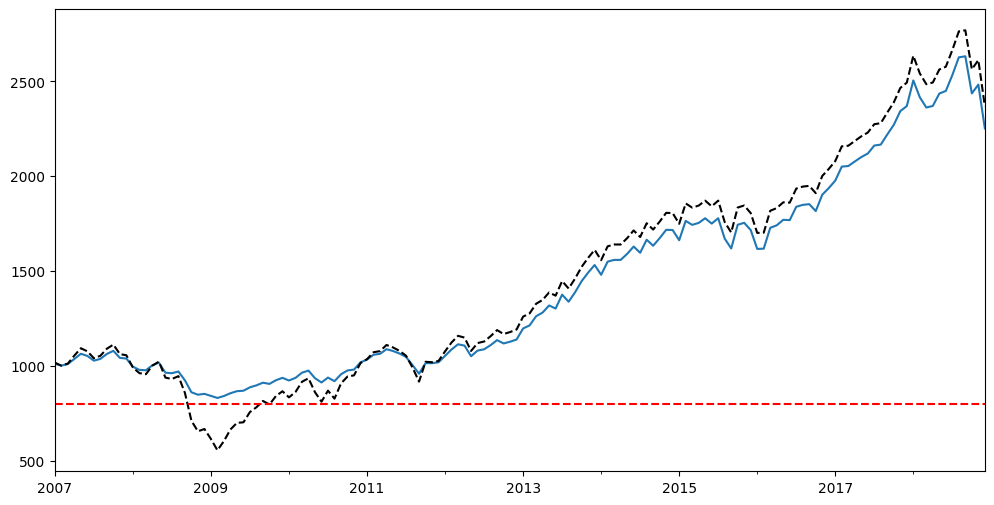

In [108]:
ax = btr2['Wealth'].plot(figsize=(12,6), legend=False)
btr2['Risky Wealth'].plot(ax = ax, style="k--", legend=False)
btr2['floor'].plot(ax=ax, color="red", linestyle="--", legend=False)

In [102]:
erk.summary_stats(btr2["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.043435,-0.734939,4.523488,0.071592,0.096315,0.972088,-0.499943


In [103]:
erk.summary_stats(btr2["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.028978,-0.588292,3.740932,0.045678,0.062953,1.323466,-0.229683


## Drawdown Constraint

In [123]:
btr3 = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)

<Axes: >

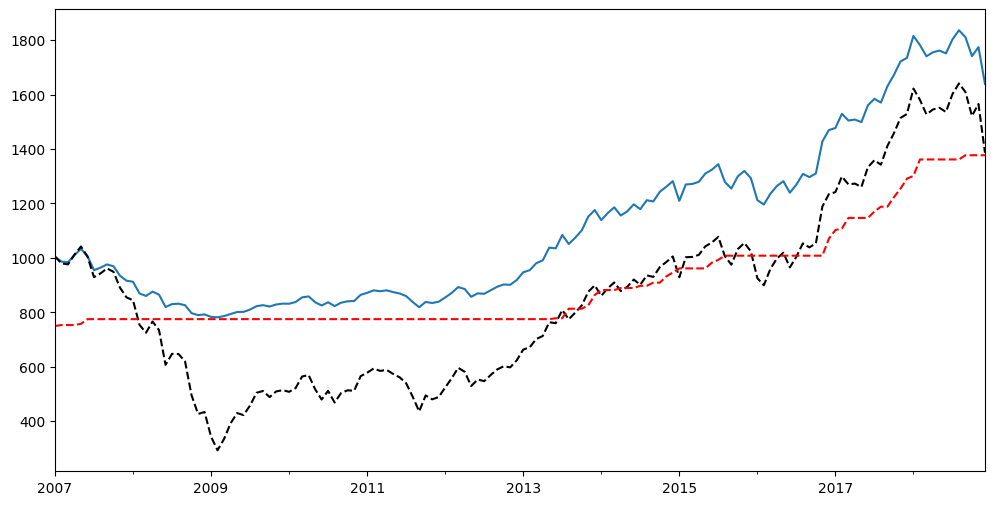

In [128]:
ind = "Fin"
ax = btr3['Wealth'][ind].plot(figsize=(12,6), legend=False)
btr3['Risky Wealth'][ind].plot(ax = ax, style="k--", legend=False)
btr3['floor'][ind].plot(ax=ax, color="red", linestyle="--", legend=False)

In [125]:
erk.summary_stats(btr3["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.088452,-0.459951,4.782828,0.152288,0.203837,-0.767792,-0.758017
Fin,0.027364,0.061258,-0.695200,4.621401,0.105744,0.149862,-0.042849,-0.718465
Beer,0.111554,0.036942,-0.670797,4.650878,0.056497,0.077388,2.148201,-0.271368


In [126]:
erk.summary_stats(btr3["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.028023,-0.441089,5.220481,0.047371,0.066991,-0.910912,-0.248059
Fin,0.041975,0.024546,-0.355163,4.153860,0.038342,0.054111,0.474456,-0.243626
Beer,0.084375,0.024902,-0.744111,4.571533,0.037937,0.051189,2.124925,-0.161186
